# Over-constraining with Integers: Why Discrete Decisions Amplify Constraint Problems

This notebook demonstrates how **over-constraining** becomes more dangerous with integer decisions. Discrete decisions have fewer feasible options, making constraints more likely to conflict.

Understanding over-constraining with integers is critical because:
- **Discrete decisions have fewer feasible options**
- **Constraints are more likely to conflict when options are limited**
- **A problem feasible with continuous variables can be infeasible with integer variables**
- **Recognizing over-constraining helps you build better models**


## Key Concepts

**Over-constraining**: Adding too many constraints or making constraints too tight.

**Why Discreteness Amplifies Over-constraining**:
- Continuous models: Many feasible solutions (smooth region)
- Discrete models: Few feasible solutions (isolated points)
- When you have fewer options, constraints are more likely to conflict
- A constraint easy to satisfy with continuous variables might be impossible with integer variables

**Critical insight**: Discrete decisions make over-constraining worse. You must be more careful about which constraints to include and how tight to make them.


## Scenario: Clinic Staffing Decision

You manage a healthcare system with multiple clinics. You need to decide how many nurses to assign to each clinic.

**The Challenge**:
- You have tight constraints: minimum staffing, maximum budget, skill requirements
- With continuous variables, the problem might be feasible
- With integer variables (whole nurses), the problem might become infeasible
- How do you recognize and fix over-constraining?


## Step 1: Install Packages


In [1]:
%pip install pulp pandas numpy matplotlib



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus


## Step 3: Define Problem Data (Tight Constraints)


In [3]:
# Problem parameters - tight constraints
num_clinics = 3
clinics = [f"Clinic_{i+1}" for i in range(num_clinics)]
min_nurses_per_clinic = 4  # Must have at least 4 nurses per clinic
cost_per_nurse = 60000  # $60,000 per nurse per year
total_budget = 700000  # Total budget: $700,000
# Note: 3 clinics × 4 nurses × $60,000 = $720,000 (exceeds budget!)

print("PROBLEM SETUP (TIGHT CONSTRAINTS):")
print("=" * 70)
print(f"Number of clinics: {num_clinics}")
print(f"Minimum nurses per clinic: {min_nurses_per_clinic}")
print(f"Cost per nurse: ${cost_per_nurse:,}")
print(f"Total budget: ${total_budget:,}")
print(f"\nMinimum required cost: {num_clinics} × {min_nurses_per_clinic} × ${cost_per_nurse:,} = ${num_clinics * min_nurses_per_clinic * cost_per_nurse:,}")
print("=" * 70)
print("\n⚠️  PROBLEM: Minimum required cost exceeds budget!")
print("This is an over-constrained problem.")


PROBLEM SETUP (TIGHT CONSTRAINTS):
Number of clinics: 3
Minimum nurses per clinic: 4
Cost per nurse: $60,000
Total budget: $700,000

Minimum required cost: 3 × 4 × $60,000 = $720,000

⚠️  PROBLEM: Minimum required cost exceeds budget!
This is an over-constrained problem.


## Step 4: Continuous Model (Might Be Feasible)

Let's see if the continuous model can find a solution:


In [4]:
# Continuous model
model_continuous = LpProblem("Clinic_Staffing_Continuous", LpMinimize)
nurses_continuous = {}
for c in clinics:
    nurses_continuous[c] = LpVariable(f"nurses_{c}", lowBound=0, cat='Continuous')

model_continuous += lpSum([nurses_continuous[c] for c in clinics]), "Total_Nurses"
for c in clinics:
    model_continuous += nurses_continuous[c] >= min_nurses_per_clinic, f"Min_{c}"
model_continuous += lpSum([cost_per_nurse * nurses_continuous[c] for c in clinics]) <= total_budget, "Budget"

model_continuous.solve()

print("CONTINUOUS MODEL:")
print("=" * 70)
print(f"Status: {LpStatus[model_continuous.status]}")
if model_continuous.status == 1:  # Optimal
    print("\nSolution:")
    for c in clinics:
        print(f"  {c}: {value(nurses_continuous[c]):.2f} nurses")
    total_cost_continuous = sum([cost_per_nurse * value(nurses_continuous[c]) for c in clinics])
    print(f"\nTotal cost: ${total_cost_continuous:,.2f}")
else:
    print("\n⚠️  Problem is INFEASIBLE even with continuous variables!")
print("=" * 70)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/22dc92200a794620b53f5b5f07ef06f4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/22dc92200a794620b53f5b5f07ef06f4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 19 RHS
At line 24 BOUNDS
At line 25 ENDATA
Problem MODEL has 4 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj 0 Primal inf 12 (3)
3  Obj 12 Primal inf 0.33333323 (1)
Primal infeasible - objective value 12
PrimalInfeasible objective 12 - 3 iterations time 0.002

Result - Lin

## Step 5: Integer Model (More Likely to Be Infeasible)

Now let's see what happens with integer constraints:


In [5]:
# Integer model
model_integer = LpProblem("Clinic_Staffing_Integer", LpMinimize)
nurses_integer = {}
for c in clinics:
    nurses_integer[c] = LpVariable(f"nurses_{c}", lowBound=0, cat='Integer')

model_integer += lpSum([nurses_integer[c] for c in clinics]), "Total_Nurses"
for c in clinics:
    model_integer += nurses_integer[c] >= min_nurses_per_clinic, f"Min_{c}"
model_integer += lpSum([cost_per_nurse * nurses_integer[c] for c in clinics]) <= total_budget, "Budget"

model_integer.solve()

print("INTEGER MODEL:")
print("=" * 70)
print(f"Status: {LpStatus[model_integer.status]}")
if model_integer.status == 1:  # Optimal
    print("\nSolution:")
    for c in clinics:
        print(f"  {c}: {int(value(nurses_integer[c]))} nurses")
    total_cost_integer = sum([cost_per_nurse * int(value(nurses_integer[c])) for c in clinics])
    print(f"\nTotal cost: ${total_cost_integer:,.2f}")
else:
    print("\n✗ Problem is INFEASIBLE with integer variables!")
    print("\nWhy? Because:")
    print(f"  - Minimum requirement: {num_clinics} clinics × {min_nurses_per_clinic} nurses = {num_clinics * min_nurses_per_clinic} nurses")
    print(f"  - Minimum cost: {num_clinics * min_nurses_per_clinic} nurses × ${cost_per_nurse:,} = ${num_clinics * min_nurses_per_clinic * cost_per_nurse:,}")
    print(f"  - Available budget: ${total_budget:,}")
    print(f"  - Gap: ${num_clinics * min_nurses_per_clinic * cost_per_nurse - total_budget:,}")
    print("\nWith integer constraints, you cannot have fractional nurses to reduce cost!")
print("=" * 70)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/f70199726dba43f7bcf2a620dc39c260-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/f70199726dba43f7bcf2a620dc39c260-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 25 RHS
At line 30 BOUNDS
At line 34 ENDATA
Problem MODEL has 4 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

INTEGER MODEL:
Status: Infeasible

✗ Problem is INFEASIBLE with integer variables!

Why? Because:
  - Minimum requirement: 3 clinics 

## Step 6: Visualizing Feasible Regions

Let's visualize why integer constraints make over-constraining worse:


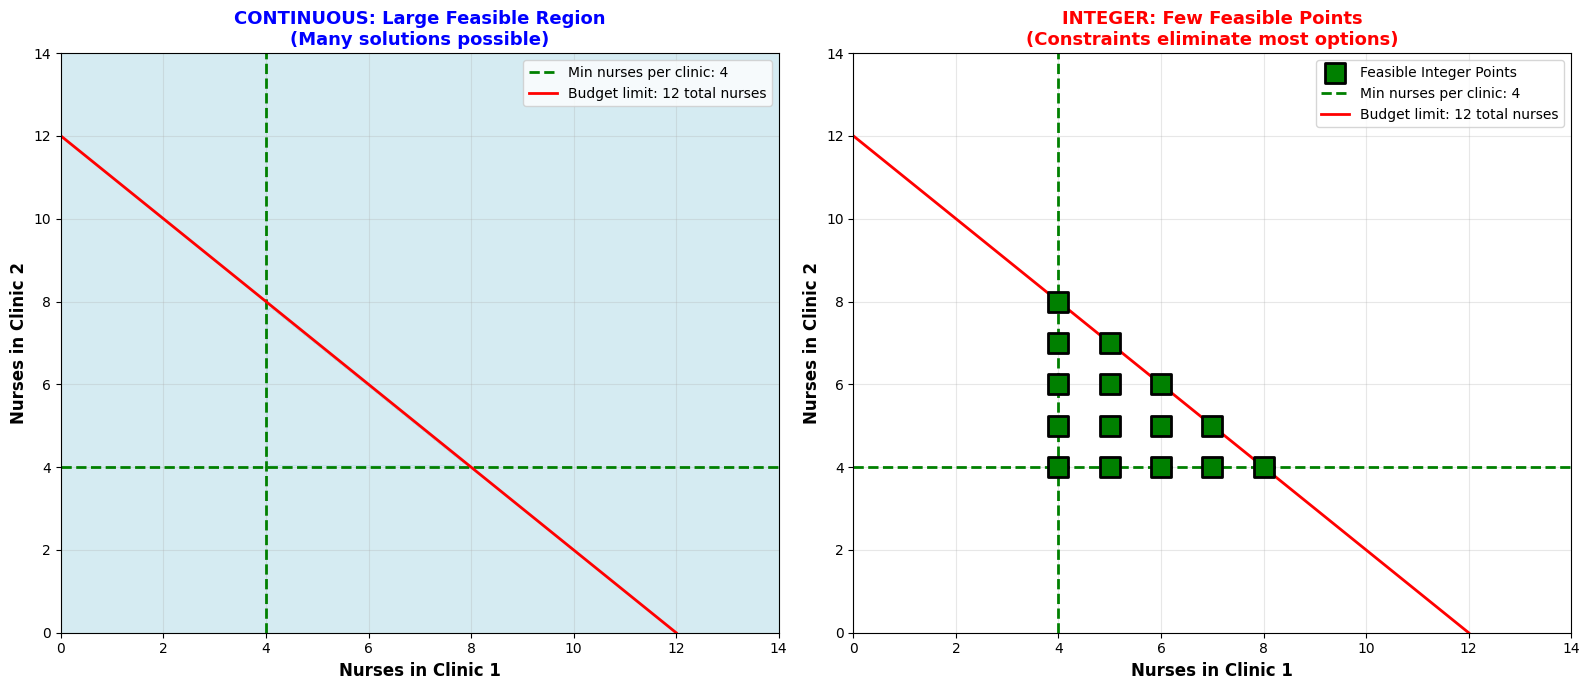


KEY VISUAL DIFFERENCE:
Continuous: Large smooth feasible region (many solutions)
Integer: Few isolated feasible points (few solutions)
When constraints are tight, integer problems become infeasible more easily!


In [6]:
# Simplified 2-clinic example for visualization
clinic1_range = np.arange(0, 15)
clinic2_range = np.arange(0, 15)

# Create grid for continuous feasible region
clinic1_cont = np.linspace(0, 14, 100)
clinic2_cont = np.linspace(0, 14, 100)
C1, C2 = np.meshgrid(clinic1_cont, clinic2_cont)

# Constraints
min_nurses = 4
budget_limit = 12  # Simplified: 12 nurses max (2 clinics × 6 nurses each = $720k)
cost_per_nurse_simple = 1  # Simplified cost

# Feasible region masks
feasible_continuous = (C1 >= min_nurses) & (C2 >= min_nurses) & ((C1 + C2) * cost_per_nurse_simple <= budget_limit)

# Integer feasible points
feasible_integer_points = []
for c1 in clinic1_range:
    for c2 in clinic2_range:
        if (c1 >= min_nurses) and (c2 >= min_nurses) and ((c1 + c2) <= budget_limit):
            feasible_integer_points.append((c1, c2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Continuous feasible region
ax1.contourf(C1, C2, feasible_continuous.astype(int), levels=[0, 0.5, 1], 
             colors=['lightblue'], alpha=0.5)
ax1.axhline(y=min_nurses, color='g', linestyle='--', linewidth=2, label=f'Min nurses per clinic: {min_nurses}')
ax1.axvline(x=min_nurses, color='g', linestyle='--', linewidth=2)
ax1.plot([0, budget_limit], [budget_limit, 0], 'r-', linewidth=2, label=f'Budget limit: {budget_limit} total nurses')
ax1.set_xlabel('Nurses in Clinic 1', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nurses in Clinic 2', fontsize=12, fontweight='bold')
ax1.set_title('CONTINUOUS: Large Feasible Region\n(Many solutions possible)', 
              fontsize=13, fontweight='bold', color='blue')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 14)
ax1.set_ylim(0, 14)

# Right plot: Integer feasible points
ax2.scatter([p[0] for p in feasible_integer_points], [p[1] for p in feasible_integer_points],
           s=200, color='green', marker='s', edgecolors='black', linewidths=2,
           label='Feasible Integer Points', zorder=3)
ax2.axhline(y=min_nurses, color='g', linestyle='--', linewidth=2, label=f'Min nurses per clinic: {min_nurses}')
ax2.axvline(x=min_nurses, color='g', linestyle='--', linewidth=2)
ax2.plot([0, budget_limit], [budget_limit, 0], 'r-', linewidth=2, label=f'Budget limit: {budget_limit} total nurses')
ax2.set_xlabel('Nurses in Clinic 1', fontsize=12, fontweight='bold')
ax2.set_ylabel('Nurses in Clinic 2', fontsize=12, fontweight='bold')
ax2.set_title('INTEGER: Few Feasible Points\n(Constraints eliminate most options)', 
              fontsize=13, fontweight='bold', color='red')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0, 14)
ax2.set_ylim(0, 14)
ax2.set_xticks(clinic1_range[::2])
ax2.set_yticks(clinic2_range[::2])

if len(feasible_integer_points) == 0:
    ax2.text(7, 7, 'NO FEASIBLE\nINTEGER POINTS!\n(Over-constrained)', 
            fontsize=14, fontweight='bold', color='red', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9))

plt.tight_layout()
plt.show()

print("\nKEY VISUAL DIFFERENCE:")
print("=" * 70)
print("Continuous: Large smooth feasible region (many solutions)")
print("Integer: Few isolated feasible points (few solutions)")
print("When constraints are tight, integer problems become infeasible more easily!")
print("=" * 70)


## Step 7: Fixing Over-constraining - Relax Constraints

How do we fix over-constraining? We need to relax some constraints:


In [7]:
# Option 1: Relax minimum nurses per clinic (reduce from 4 to 3)
min_nurses_relaxed = 3

model_relaxed = LpProblem("Clinic_Staffing_Relaxed", LpMinimize)
nurses_relaxed = {}
for c in clinics:
    nurses_relaxed[c] = LpVariable(f"nurses_{c}", lowBound=0, cat='Integer')

model_relaxed += lpSum([nurses_relaxed[c] for c in clinics]), "Total_Nurses"
for c in clinics:
    model_relaxed += nurses_relaxed[c] >= min_nurses_relaxed, f"Min_{c}"
model_relaxed += lpSum([cost_per_nurse * nurses_relaxed[c] for c in clinics]) <= total_budget, "Budget"

model_relaxed.solve()

print("RELAXED CONSTRAINTS MODEL:")
print("=" * 70)
print(f"Relaxed minimum nurses per clinic: {min_nurses_relaxed} (was {min_nurses_per_clinic})")
print(f"Status: {LpStatus[model_relaxed.status]}")
if model_relaxed.status == 1:  # Optimal
    print("\nSolution:")
    for c in clinics:
        print(f"  {c}: {int(value(nurses_relaxed[c]))} nurses")
    total_cost_relaxed = sum([cost_per_nurse * int(value(nurses_relaxed[c])) for c in clinics])
    total_nurses_relaxed = sum([int(value(nurses_relaxed[c])) for c in clinics])
    print(f"\nTotal nurses: {total_nurses_relaxed}")
    print(f"Total cost: ${total_cost_relaxed:,.2f}")
    print(f"Budget remaining: ${total_budget - total_cost_relaxed:,.2f}")
    print("\n✓ Problem is now FEASIBLE!")
else:
    print("\n✗ Still infeasible - need to relax more constraints")
print("=" * 70)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/345d3a7745d5421aa0b0e55c749eca9a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/345d3a7745d5421aa0b0e55c749eca9a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 25 RHS
At line 30 BOUNDS
At line 34 ENDATA
Problem MODEL has 4 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 9 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of w

## Step 8: Comparing Constraint Tightness

Let's compare different levels of constraint tightness:


In [8]:
# Test different minimum nurse requirements
min_nurses_options = [2, 3, 4, 5]
results = []

for min_nurses_test in min_nurses_options:
    model_test = LpProblem("Clinic_Staffing_Test", LpMinimize)
    nurses_test = {}
    for c in clinics:
        nurses_test[c] = LpVariable(f"nurses_{c}", lowBound=0, cat='Integer')
    
    model_test += lpSum([nurses_test[c] for c in clinics]), "Total_Nurses"
    for c in clinics:
        model_test += nurses_test[c] >= min_nurses_test, f"Min_{c}"
    model_test += lpSum([cost_per_nurse * nurses_test[c] for c in clinics]) <= total_budget, "Budget"
    
    model_test.solve()
    
    if model_test.status == 1:  # Optimal
        total_nurses = sum([int(value(nurses_test[c])) for c in clinics])
        total_cost = sum([cost_per_nurse * int(value(nurses_test[c])) for c in clinics])
        results.append({
            'Min Nurses/Clinic': min_nurses_test,
            'Status': 'Feasible',
            'Total Nurses': total_nurses,
            'Total Cost': f'${total_cost:,.0f}',
            'Budget Used': f'{total_cost/total_budget*100:.1f}%'
        })
    else:
        min_cost = num_clinics * min_nurses_test * cost_per_nurse
        results.append({
            'Min Nurses/Clinic': min_nurses_test,
            'Status': 'Infeasible',
            'Total Nurses': 'N/A',
            'Total Cost': f'${min_cost:,.0f} (min)',
            'Budget Used': f'{min_cost/total_budget*100:.1f}% (exceeds)'
        })

results_df = pd.DataFrame(results)

print("CONSTRAINT TIGHTNESS COMPARISON:")
print("=" * 80)
display(results_df)
print("=" * 80)

print("\nKEY INSIGHT:")
print("As minimum nurses per clinic increases, the problem becomes infeasible.")
print("With integer constraints, you have fewer options to satisfy tight constraints!")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/22b130367d004666bb0bb9ddcf24f0bd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/22b130367d004666bb0bb9ddcf24f0bd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 25 RHS
At line 30 BOUNDS
At line 34 ENDATA
Problem MODEL has 4 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 6 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of w

,Min Nurses/Clinic,Status,Total Nurses,Total Cost,Budget Used
0,2,Feasible,6,"$360,000",51.4%
1,3,Feasible,9,"$540,000",77.1%
2,4,Infeasible,N/A,"$720,000 (min)",102.9% (exceeds)
3,5,Infeasible,N/A,"$900,000 (min)",128.6% (exceeds)



KEY INSIGHT:
As minimum nurses per clinic increases, the problem becomes infeasible.
With integer constraints, you have fewer options to satisfy tight constraints!


## Step 9: Real-World Example - Facility Location

Let's see how over-constraining affects facility location decisions:


In [9]:
# Facility location scenario with tight constraints
facilities = ['Facility A', 'Facility B', 'Facility C']
fixed_costs = {'Facility A': 200000, 'Facility B': 250000, 'Facility C': 300000}
capacities = {'Facility A': 1000, 'Facility B': 1500, 'Facility C': 2000}
min_capacity_needed = 3500  # Need at least 3500 units capacity
budget_facilities = 600000  # Budget: $600,000

# Check if it's feasible
min_cost_if_all_open = sum(fixed_costs.values())
print("FACILITY LOCATION SCENARIO:")
print("=" * 70)
print(f"Minimum capacity needed: {min_capacity_needed:,} units")
print(f"Budget available: ${budget_facilities:,}")
print(f"\nIf we open all facilities:")
print(f"  Total capacity: {sum(capacities.values()):,} units")
print(f"  Total cost: ${min_cost_if_all_open:,}")
print("=" * 70)

# Integer model (binary: open or not)
model_facilities = LpProblem("Facility_Location", LpMinimize)
open_facility = {}
for f in facilities:
    open_facility[f] = LpVariable(f"open_{f.replace(' ', '_')}", cat='Binary')

model_facilities += lpSum([fixed_costs[f] * open_facility[f] for f in facilities]), "Total_Cost"
model_facilities += lpSum([capacities[f] * open_facility[f] for f in facilities]) >= min_capacity_needed, "Min_Capacity"
model_facilities += lpSum([fixed_costs[f] * open_facility[f] for f in facilities]) <= budget_facilities, "Budget"

model_facilities.solve()

print("\nSOLUTION:")
print("=" * 70)
print(f"Status: {LpStatus[model_facilities.status]}")
if model_facilities.status == 1:  # Optimal
    print("\nFacilities to open:")
    for f in facilities:
        if value(open_facility[f]) > 0.5:
            print(f"  ✓ {f}: Open")
        else:
            print(f"  ✗ {f}: Closed")
    total_cost_fac = sum([fixed_costs[f] * value(open_facility[f]) for f in facilities])
    total_capacity_fac = sum([capacities[f] * value(open_facility[f]) for f in facilities])
    print(f"\nTotal cost: ${total_cost_fac:,.0f}")
    print(f"Total capacity: {total_capacity_fac:,} units")
else:
    print("\n✗ Problem is INFEASIBLE!")
    print("\nWhy? Because:")
    print(f"  - Minimum capacity needed: {min_capacity_needed:,} units")
    print(f"  - To meet capacity, must open facilities costing at least ${min_cost_if_all_open:,}")
    print(f"  - Available budget: ${budget_facilities:,}")
    print(f"  - With binary (0/1) decisions, you cannot partially open facilities!")
    print("\n✓ SOLUTION: Relax constraints (reduce min capacity or increase budget)")
print("=" * 70)


FACILITY LOCATION SCENARIO:
Minimum capacity needed: 3,500 units
Budget available: $600,000

If we open all facilities:
  Total capacity: 4,500 units
  Total cost: $750,000
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e59612574cdc4f2ba577f32b3323d30e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e59612574cdc4f2ba577f32b3323d30e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 23 RHS
At line 26 BOUNDS
At line 30 ENDATA
Problem MODEL has 2 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 550000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which b

## Summary

**Key Takeaways:**

1. **Over-constraining is worse with integers**: Discrete decisions have fewer feasible options, making constraints more likely to conflict.

2. **Continuous vs Integer feasibility**: A problem feasible with continuous variables can be infeasible with integer variables because you cannot make fractional adjustments.

3. **Recognizing over-constraining**: 
   - Check if minimum requirements exceed available resources
   - Visualize feasible regions (continuous = large, integer = small)
   - Test if relaxing constraints makes the problem feasible

4. **Fixing over-constraining**:
   - Relax constraint values (e.g., reduce minimum requirements)
   - Remove less critical constraints
   - Increase available resources (e.g., increase budget)
   - Prioritize constraints and relax less important ones

5. **Why this matters**:
   - Over-constrained models waste time and effort
   - They produce no solutions (infeasible)
   - Understanding over-constraining helps you build better models
   - It helps you recognize when constraints need to be relaxed

**Common Signs of Over-constraining:**
- ❌ Model status is "Infeasible"
- ❌ Minimum requirements exceed available resources
- ❌ Multiple tight constraints that conflict with each other
- ❌ Problem is feasible with continuous but infeasible with integer variables

**Best Practices:**
- Start with essential constraints only
- Test feasibility as you add constraints
- Be willing to relax less critical constraints
- Recognize that integer constraints make over-constraining more dangerous
